# iEEG Data

This notebook analyses a large dataset of iEEG data, from the MNI database. 

## Dataset Details

This analysis uses the openly available MNI dataset.

In [1]:
# Setup notebook state
from nbutils import setup_notebook; setup_notebook()

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from fooof import FOOOF, FOOOFGroup
from fooof.plts import plot_spectra
from fooof.analysis import get_band_peak_fg
from neurodsp.utils import create_times
from neurodsp.aperiodic import compute_irasa
from neurodsp.spectral import compute_spectrum, trim_spectrum
from neurodsp.plts import plot_time_series, plot_power_spectra
from neurodsp.plts.utils import make_axes

In [4]:
# Import custom project code
from apm.io import APMDB, get_files, load_pickle
from apm.io.data import load_ieeg_all
from apm.analysis import (compute_all_corrs, unpack_corrs,
                          compute_corrs_to_feature, compute_diffs_to_feature)
from apm.plts import plot_dots, plot_corr_matrix
from apm.plts.multi import plot_results_all
from apm.plts.utils import figsaver
from apm.plts.settings import LABELS
from apm.utils import format_corr

In [5]:
# Import dataset settings from script
import sys; from pathlib import Path;
sys.path.append(str(Path('..').resolve() / 'scripts'))
from scripts.analyze_ieeg import (DATA_FOLDER, NON_CORTICAL, FS, MAX_TIME,
                                  FIT_RANGE_SHORT, FIT_RANGE_LONG)
from scripts.settings import SPECPARAM_SETTINGS, SPECPARAM_SETTINGS_KNEE

## Set Up Paths

In [6]:
# Define load path
db = APMDB()
LOADPATH = db.data_path / 'ieeg'

In [7]:
# Check the set of results files available for this dataset
get_files(LOADPATH)

['ieeg_all_corrs.p',
 'ieeg_results.p',
 'ieeg_specparam.json',
 'ieeg_specparam_long.json',
 'ieeg_specparam_short.json']

## Settings

In [8]:
# Define band range for peaks
peak_range = [2, 35]

In [9]:
# Add plot kwargs
dot_kwargs = {
    's' : 16,
    'alpha' : 0.4,
}

In [10]:
# Settings for saving figures
SAVE_FIG = True
FIGPATH = db.figs_path / '53_ieeg_data'

# Create helper function to manage figsaver settings
fsaver = figsaver(SAVE_FIG, FIGPATH)

## Load Data

In [11]:
# Get the list of available files
files = get_files(DATA_FOLDER)

In [12]:
# Check the number of files
n_files = len(files)
print('Number of files: {}'.format(n_files))

Number of files: 38


In [13]:
# Load all data files
all_data, all_chs = load_ieeg_all(files, DATA_FOLDER, MAX_TIME, NON_CORTICAL, return_channels=True)

In [14]:
# Create times definition
times = create_times(MAX_TIME, FS)

In [15]:
# Check data size
n_chs, n_times = all_data.shape
print('Number of channels: {}'.format(n_chs))

Number of channels: 1479


## Data Checks

In [16]:
# Set example channel index
chi = 550

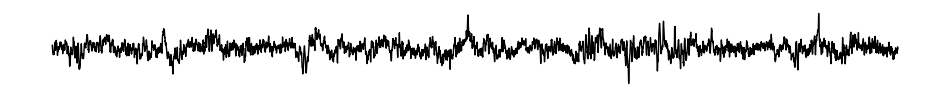

In [17]:
# Plot an example time series
plot_time_series(times, all_data[chi, :], lw=1., figsize=(12, 1))
plt.gca().axis('off');

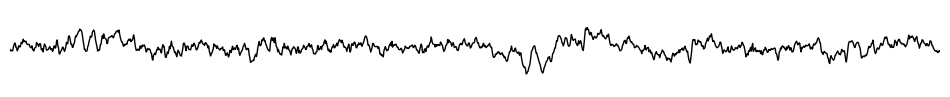

In [18]:
# Plot a zoomed in segment of a time series
plot_time_series(times, all_data[chi, :], xlim=[5, 12], lw=1., figsize=(12, 1))
plt.gca().axis('off');
if SAVE_FIG: plt.savefig(FIGPATH / ('ieeg_timeseries.pdf'))

In [19]:
# Compute a power spectrum of an example
freqs, powers = compute_spectrum(all_data[chi, :], FS, nperseg=2*FS, noverlap=FS)

In [20]:
# Trim spectrum to fit range
freqs, powers = trim_spectrum(freqs, powers, FIT_RANGE_LONG)

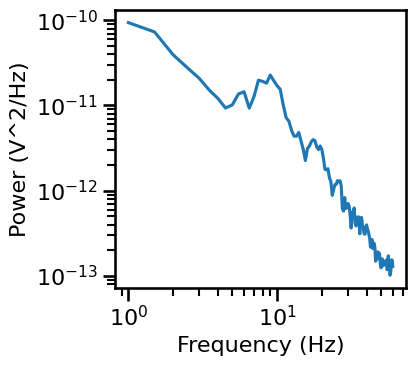

In [21]:
# Plot the power spectrum
plot_power_spectra(freqs, powers, figsize=(4.5, 4), **fsaver('ieeg_psd'))

### Check Spectral Fits - Short Fit Range

In [22]:
# Load specparam measures
fg_short = FOOOFGroup()
fg_short.load('ieeg_specparam_short', LOADPATH)

                                                                                                  
                                       FOOOF - GROUP RESULTS                                      
                                                                                                  
                            Number of power spectra in the Group: 1479                            
                                                                                                  
                        The model was run on the frequency range 3 - 40 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                              Power spectra were fit without a knee.                              
                                                                                                  
          

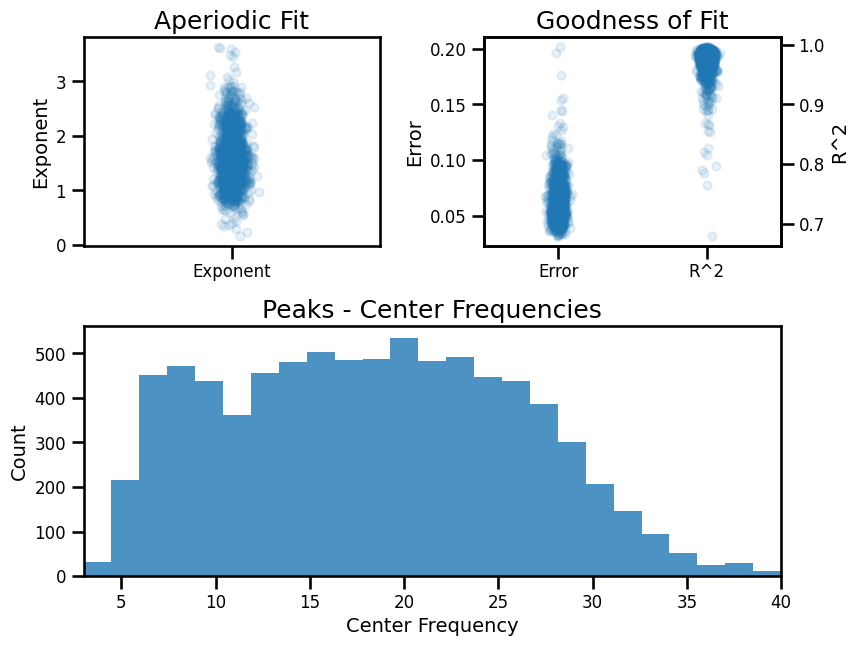

In [23]:
# Check overall group results
fg_short.print_results()
fg_short.plot()

## Example Spectral Model - Short Fit Range

In [24]:
# Set example channel index
chi = 550

In [25]:
# Compute a power spectrum of an example signal, and trim to fit range
freqs, powers = compute_spectrum(all_data[chi, :], FS, nperseg=2*FS, noverlap=FS)
freqs, powers = trim_spectrum(freqs, powers, FIT_RANGE_SHORT)

In [26]:
# Fit a spectral model to example data
fm = FOOOF(**SPECPARAM_SETTINGS)
fm.fit(freqs, powers, FIT_RANGE_SHORT)

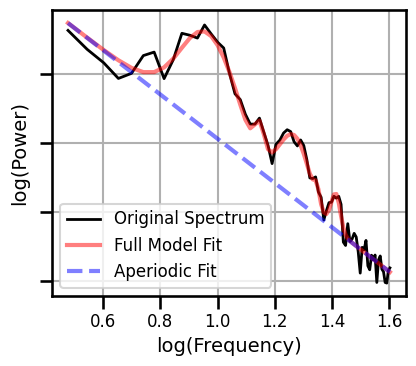

In [27]:
# Plot the specparam spectral model
fm.plot(plt_log=True, figsize=(4.5, 4), yticklabels=[],
        **fsaver('ieeg_spectral_model_short'))

#### IRASA

In [28]:
# Compute the IRASA decomposition
freqs_ir, psd_ap, psd_pe = compute_irasa(all_data[chi, :], FS, FIT_RANGE_SHORT)

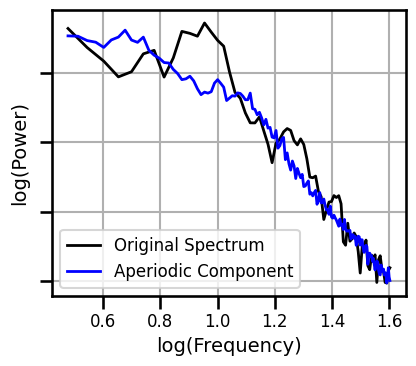

In [29]:
# Plot the IRASA data & aperiodic component
plot_spectra([freqs, freqs_ir], [powers, psd_ap], log_freqs=True, figsize=(4.5, 4),
             log_powers=True, colors=['black', 'blue'], yticklabels=[],
             labels=['Original Spectrum', 'Aperiodic Component'],
             **fsaver('ieeg_irasa_model_short'))

### Check Spectral Fits - Long Fit Range

In [30]:
# Load specparam measures
fg_long = FOOOFGroup()
fg_long.load('ieeg_specparam_long', LOADPATH)

                                                                                                  
                                       FOOOF - GROUP RESULTS                                      
                                                                                                  
                            Number of power spectra in the Group: 1479                            
                                                                                                  
                        The model was run on the frequency range 1 - 60 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                               Power spectra were fit with a knee.                                
                                                                                                  
          

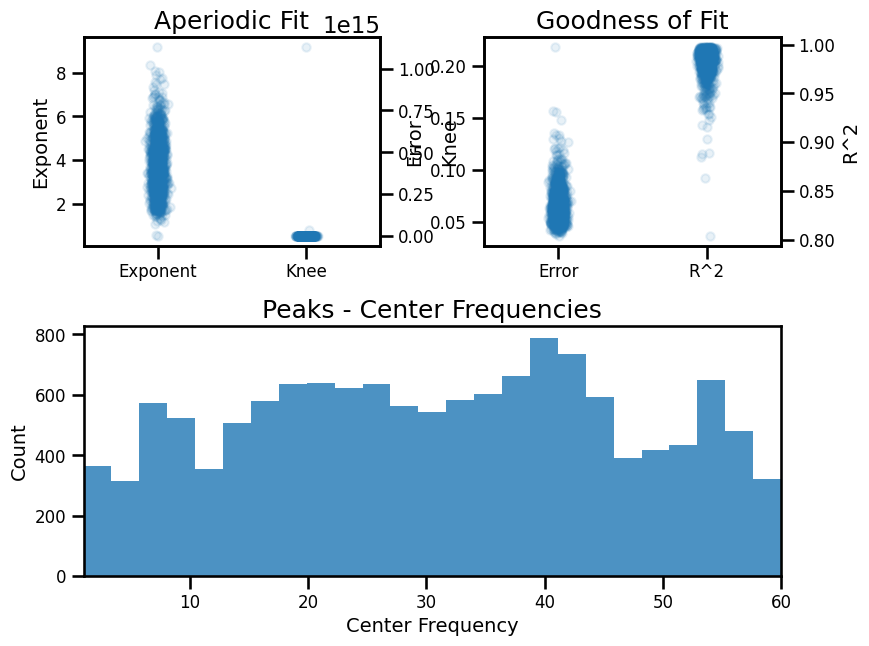

In [31]:
# Check overall group results
fg_long.print_results()
fg_long.plot()

## Example Spectral Model - Long Fit Range

In [32]:
# Set example channel index
chi = 813

In [33]:
# Compute a power spectrum of an example signal, and trim to fit rante
freqs, powers = compute_spectrum(all_data[chi, :], FS, nperseg=2*FS, noverlap=FS)
freqs, powers = trim_spectrum(freqs, powers, FIT_RANGE_LONG)

In [34]:
# Fit a spectral model to example data
fm = FOOOF(**SPECPARAM_SETTINGS_KNEE)
fm.fit(freqs, powers, FIT_RANGE_LONG)

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/trf.py:234: RuntimeWarning: divide by zero encountered in divide
  Delta = norm(x0 * scale_inv / v**0.5)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/trf.py:363: RuntimeWarning: invalid value encountered in scalar divide
  alpha *= Delta / Delta_new
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:49: RuntimeWarning: invalid value encountered in scalar divide
  t2 = c / q
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/trf.py:363: RuntimeWarning: invalid value encountered in scalar multiply
  alpha *= Delta / Delta_new
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)


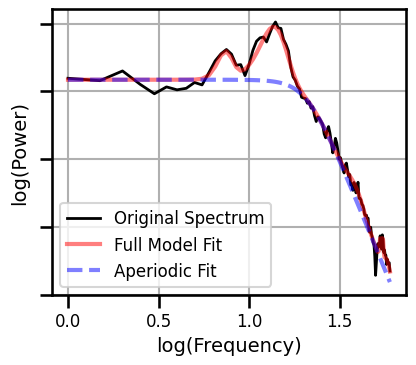

In [35]:
# Plot the specparam spectral model
fm.plot(plt_log=True, figsize=(4.5, 4), yticklabels=[],
        **fsaver('ieeg_spectral_model_long'))

#### IRASA

In [36]:
# Compute the IRASA decomposition
freqs_ir, psd_ap, psd_pe = compute_irasa(all_data[chi, :], FS, FIT_RANGE_LONG)

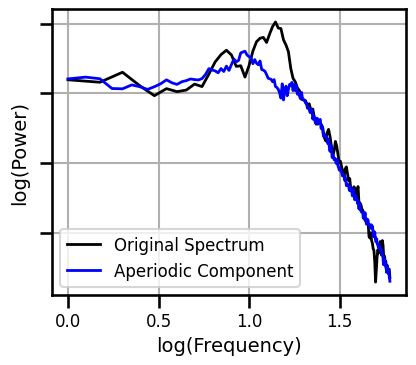

In [37]:
# Plot the IRASA data & aperiodic component
plot_spectra([freqs, freqs_ir], [powers, psd_ap], log_freqs=True, figsize=(4.5, 4),
             log_powers=True, colors=['black', 'blue'], yticklabels=[],
             labels=['Original Spectrum', 'Aperiodic Component'],
             **fsaver('ieeg_irasa_model_long'))

## Load Results

In [38]:
# Load precomputed aperiodic measure results
results = load_pickle('ieeg_results', LOADPATH)

In [39]:
# Check size of computed results [n_chs]
results['dfa'].shape

(1479,)

### Check Measures & Labels

In [40]:
# Check list of computed measures
print(list(results.keys()))

['autocorr_decay_time', 'dfa', 'higuchi_fd', 'hjorth_complexity', 'lempelziv', 'sample_entropy', 'perm_entropy', 'specparam_short', 'specparam_long', 'specparam_knee', 'specparam_knee_freq', 'irasa_short', 'irasa_long', 'irasa_knee', 'irasa_knee_freq']


In [41]:
# Collect list of exponent & timeseries measure labels
exp_measures = ['specparam_short', 'specparam_long', 'irasa_short', 'irasa_long']
knee_measures = ['specparam_knee', 'specparam_knee_freq', 'irasa_knee', 'irasa_knee_freq']
ts_measures = list(results.keys())
[ts_measures.remove(meas) for meas in exp_measures + knee_measures];

In [42]:
# Collect labels for time series measures
ts_labels = [LABELS[meas] for meas in ts_measures]

### Compute Correlations

In [43]:
# Load precomputed aperiodic measure results
all_corrs = load_pickle('ieeg_all_corrs', LOADPATH)

In [44]:
# # Compute correlations across all pairs of methods
# all_corrs = compute_all_corrs(results)

#### Compare exponent measures - short

In [45]:
# Check exponent data ranges
print('SP: {:1.2f}-{:1.2f}'.format(np.min(results['specparam_short']),
                                   np.max(results['specparam_short'])))
print('IR: {:1.2f}-{:1.2f}'.format(np.min(results['irasa_short']),
                                   np.max(results['irasa_short'])))

SP: 0.16-3.64
IR: 0.13-4.03


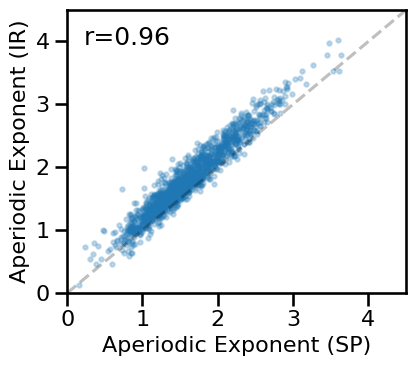

In [46]:
# Compare aperiodic exponent from specparam & IRASA
plot_dots(results['specparam_short'], results['irasa_short'], alpha=0.25, tposition='tl',
          xlim=[0, 4.5], ylim=[0, 4.5], expected=[0, 4.5], s=10, figsize=(4.5, 4),
          xlabel='Aperiodic Exponent (SP)', ylabel='Aperiodic Exponent (IR)',
          **fsaver('ieeg_exp_exp_short'))

In [47]:
# Check correlation between exponent estimates
print('  SP-EXP & IR-EXP:  ', format_corr(*all_corrs['specparam_short']['irasa_short']))

  SP-EXP & IR-EXP:   r=+0.956  CI[+0.949, +0.962],  p=0.000


In [48]:
# Compute average difference between exponent estimates
exp_diffs_short = np.abs(results['specparam_short'] - results['irasa_short'])

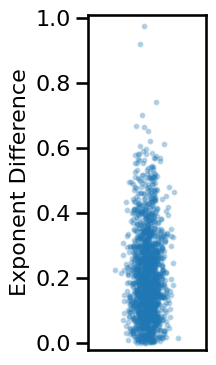

In [49]:
# Plot the distribution of differences between exponent measures
plot_dots(np.random.randn(len(exp_diffs_short)) * 0.15, exp_diffs_short,
          add_corr=False, figsize=(2.5, 4), xticks=[], xlim=[-1, 1],
          ylim=[-0.02, 1.01], ylabel='Exponent Difference', alpha=0.25, s=8,
          **fsaver('ieeg_exp_diffs'))

In [50]:
# Check median and range of exponent differences
print('Median exp diff: \t{:1.2f}'.format(np.median(exp_diffs_short)))
print('Min/Max: \t\t{:1.2f}, {:1.2f}'.format(np.min(exp_diffs_short),
                                             np.max(exp_diffs_short)))

Median exp diff: 	0.19
Min/Max: 		0.00, 0.97


#### Compare exponent measures - long

In [51]:
# Check exponent data ranges
print('SP: {:1.2f}-{:1.2f}'.format(np.min(results['specparam_long']),
                                   np.max(results['specparam_long'])))
print('IR: {:1.2f}-{:1.2f}'.format(np.min(results['irasa_long']),
                                   np.max(results['irasa_long'])))

SP: 0.51-9.21
IR: 0.49-9.98


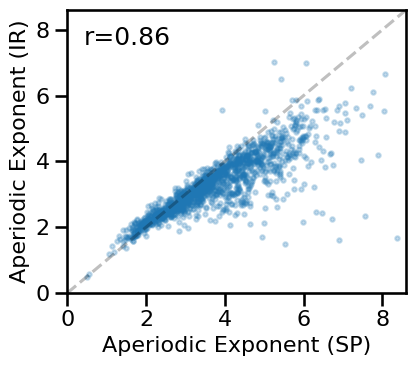

In [52]:
# Compare aperiodic exponent from specparam & IRASA
plot_dots(results['specparam_long'], results['irasa_long'], alpha=0.25, tposition='tl',
          xlim=[0, 8.6], ylim=[0, 8.6], expected=[0, 8.6], s=10, figsize=(4.5, 4),
          xlabel='Aperiodic Exponent (SP)', ylabel='Aperiodic Exponent (IR)',
          **fsaver('ieeg_exp_exp_long'))

In [53]:
# Check correlation between exponent estimates
print('  SP-EXP & IR-EXP:  ', format_corr(*all_corrs['specparam_long']['irasa_long']))

  SP-EXP & IR-EXP:   r=+0.862  CI[+0.836, +0.886],  p=0.000


In [54]:
# Compute average difference between exponent estimates
exp_diffs_long = np.abs(results['specparam_long'] - results['irasa_long'])

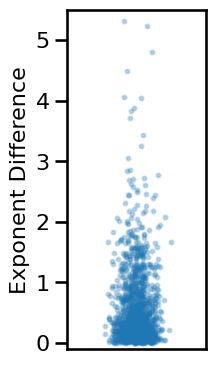

In [55]:
# Plot the distribution of differences between exponent measures
plot_dots(np.random.randn(len(exp_diffs_long)) * 0.15, exp_diffs_long, add_corr=False,
          xticks=[], xlim=[-1, 1], ylim=[-0.1, 5.5], ylabel='Exponent Difference',
          alpha=0.25, s=8, figsize=(2.5, 4), **fsaver('ieeg_exp_diffs'))

In [56]:
# Check median and range of exponent differences
print('Median exp diff: \t{:1.2f}'.format(np.median(exp_diffs_long)))
print('Min/Max: \t\t{:1.2f}, {:1.2f}'.format(np.min(exp_diffs_long),
                                             np.max(exp_diffs_long)))

Median exp diff: 	0.30
Min/Max: 		0.00, 6.86


#### Compare knee measures

In [57]:
# Check knee data ranges
print('SP: {:1.2f}-{:1.2f}'.format(np.min(results['specparam_knee_freq']),
                                   np.max(results['specparam_knee_freq'])))
print('IR: {:1.2f}-{:1.2f}'.format(np.min(results['irasa_knee_freq']),
                                   np.max(results['irasa_knee_freq'])))

SP: 0.00-43.18
IR: 0.00-34.10


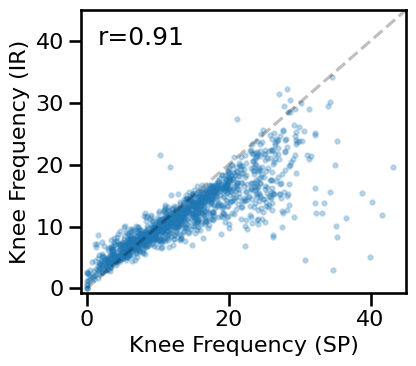

In [58]:
# Compare aperiodic exponent from specparam & IRASA
plot_dots(results['specparam_knee_freq'], results['irasa_knee_freq'], alpha=0.25, tposition='tl',
          xlim=[-0.75, 45], ylim=[-0.75, 45], expected=[-0, 45], s=10, figsize=(4.5, 4),
          xlabel='Knee Frequency (SP)', ylabel='Knee Frequency (IR)', **fsaver('ieeg_knee_knee'))

In [59]:
# Check correlation between knee estimates
print('  SP-KNEE & IR-KNEE:  ', format_corr(*all_corrs['specparam_knee_freq']['irasa_knee_freq']))

  SP-KNEE & IR-KNEE:   r=+0.908  CI[+0.890, +0.924],  p=0.000


In [60]:
# Compute average difference between knee estimates
knee_diffs = np.abs(results['specparam_knee_freq'] - results['irasa_knee_freq'])

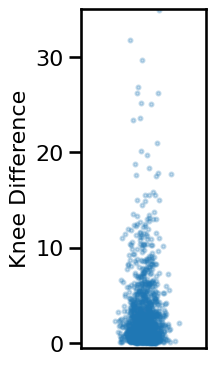

In [61]:
# Plot the distribution of differences between knee measures
plot_dots(np.random.randn(len(knee_diffs)) * 0.15, knee_diffs, add_corr=False,
          xticks=[], xlim=[-1, 1], ylim=[-0.5, 35], figsize=(2.5, 4),
          ylabel='Knee Difference', alpha=0.25, s=8, **fsaver('ieeg_knee_diffs'))

In [62]:
# Check median and range of knee differences
print('Median exp diff: \t{:1.2f}'.format(np.median(knee_diffs)))
print('Min/Max: \t\t{:1.2f}, {:1.2f}'.format(np.min(knee_diffs), np.max(knee_diffs)))

Median exp diff: 	1.62
Min/Max: 		0.00, 34.93


#### Compare Parameters Within Method

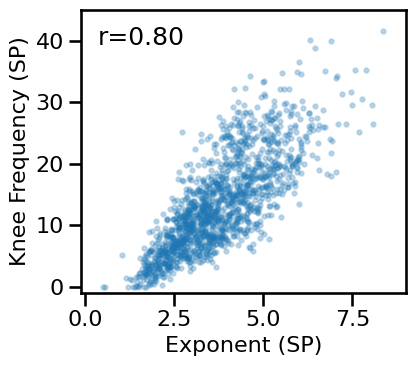

In [63]:
# Compare aperiodic parameters from within each method - specparam
plot_dots(results['specparam_long'], results['specparam_knee_freq'], alpha=0.25, tposition='tl',
          xlim=[-0.1, 9], ylim=[-1, 45], s=10, figsize=(4.5, 4), xlabel='Exponent (SP)', 
          ylabel='Knee Frequency (SP)', **fsaver('ieeg_specparam_params'))

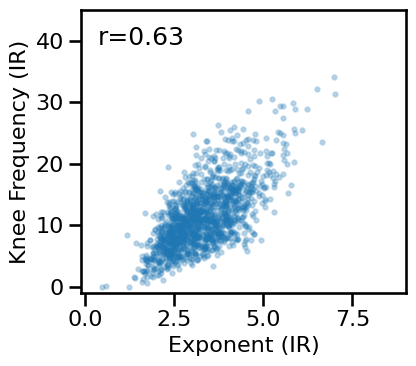

In [64]:
# Compare aperiodic parameters from within each method - irasa
plot_dots(results['irasa_long'], results['irasa_knee_freq'], alpha=0.25, tposition='tl',
          xlim=[-0.1, 9], ylim=[-1, 45], s=10, figsize=(4.5, 4), xlabel='Exponent (IR)', 
          ylabel='Knee Frequency (IR)', **fsaver('ieeg_irasa_params'))

#### Compare Different Exponents

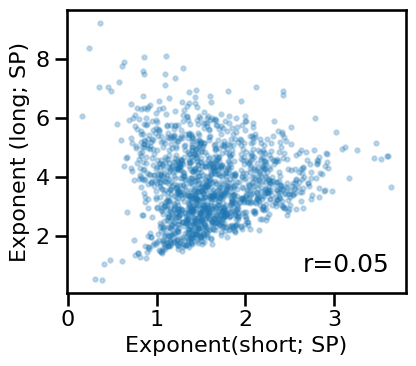

In [65]:
# Compare exponent estimates from within method / across ranges - specparam
plot_dots(results['specparam_short'], results['specparam_long'], alpha=0.25,
          tposition='br', s=10, figsize=(4.5, 4), xlabel='Exponent(short; SP)',
          ylabel='Exponent (long; SP)', **fsaver('ieeg_specparam_exps'))

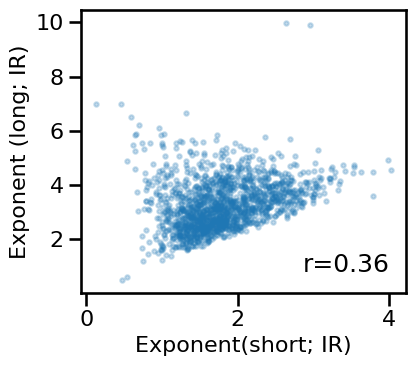

In [66]:
# Compare exponent estimates from within method / across ranges - irasa
plot_dots(results['irasa_short'], results['irasa_long'], alpha=0.25,
          tposition='br', s=10, figsize=(4.5, 4), xlabel='Exponent(short; IR)',
          ylabel='Exponent (long; IR)', **fsaver('ieeg_irasa_exps'))

### Compare exponent to other measures - long

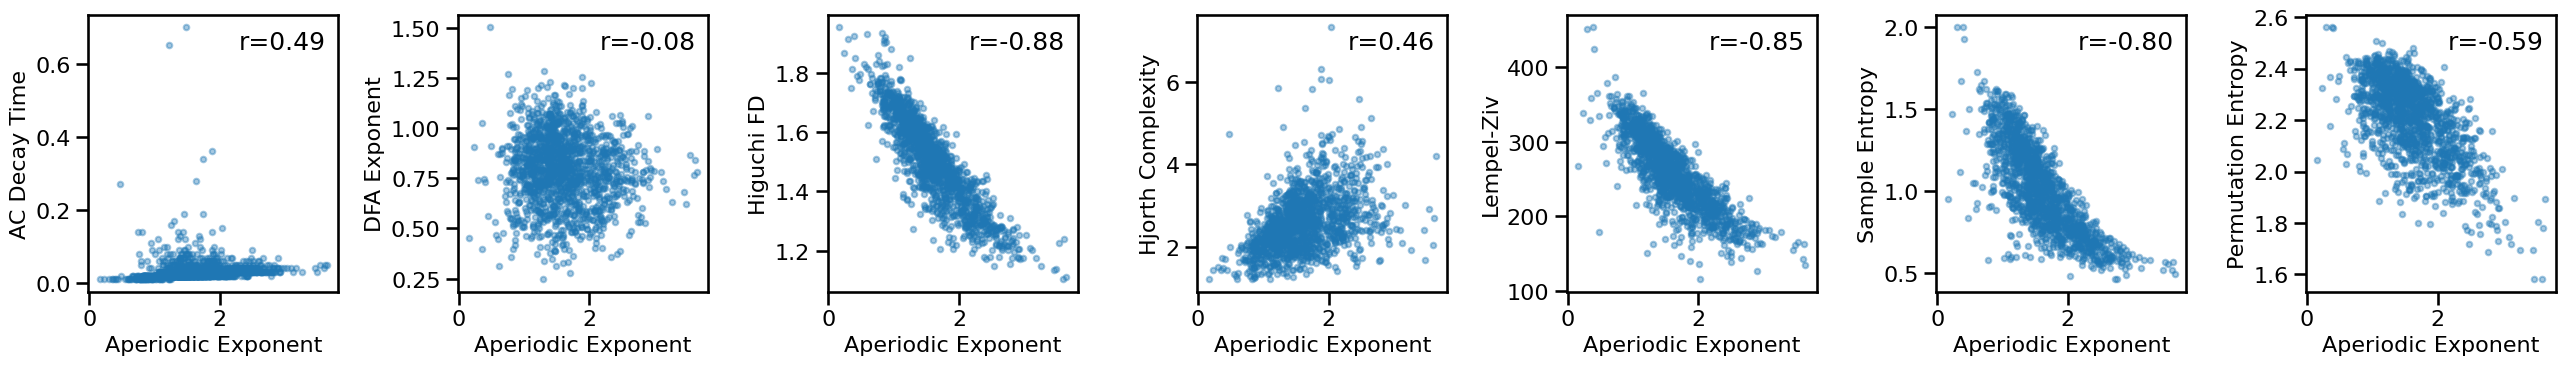

In [67]:
# Plot comparisons between exponent and time series measures
axes = make_axes(1, len(ts_measures), figsize=(26, 4), wspace=0.4)
for ind, meas in enumerate(ts_measures):
    plot_dots(results['specparam_short'], results[meas], **dot_kwargs,
              xlabel='Aperiodic Exponent', ylabel=LABELS[meas], ax=axes[ind])

In [68]:
# Check the correlations between time series and exponent measures
for meas in ts_measures:
    print(meas)
    print('    SP-EXP:  ', format_corr(*all_corrs['specparam_short'][meas]))
    print('    IR-EXP:  ', format_corr(*all_corrs['irasa_short'][meas]))

autocorr_decay_time
    SP-EXP:   r=+0.486  CI[+0.441, +0.527],  p=0.000
    IR-EXP:   r=+0.430  CI[+0.384, +0.474],  p=0.000
dfa
    SP-EXP:   r=-0.082  CI[-0.132, -0.033],  p=0.002
    IR-EXP:   r=-0.179  CI[-0.227, -0.130],  p=0.000
higuchi_fd
    SP-EXP:   r=-0.885  CI[-0.898, -0.870],  p=0.000
    IR-EXP:   r=-0.963  CI[-0.968, -0.957],  p=0.000
hjorth_complexity
    SP-EXP:   r=+0.459  CI[+0.416, +0.500],  p=0.000
    IR-EXP:   r=+0.394  CI[+0.347, +0.438],  p=0.000
lempelziv
    SP-EXP:   r=-0.848  CI[-0.865, -0.829],  p=0.000
    IR-EXP:   r=-0.858  CI[-0.874, -0.840],  p=0.000
sample_entropy
    SP-EXP:   r=-0.796  CI[-0.819, -0.770],  p=0.000
    IR-EXP:   r=-0.837  CI[-0.858, -0.815],  p=0.000
perm_entropy
    SP-EXP:   r=-0.595  CI[-0.628, -0.558],  p=0.000
    IR-EXP:   r=-0.668  CI[-0.699, -0.635],  p=0.000


### Compare exponent to other measures - long

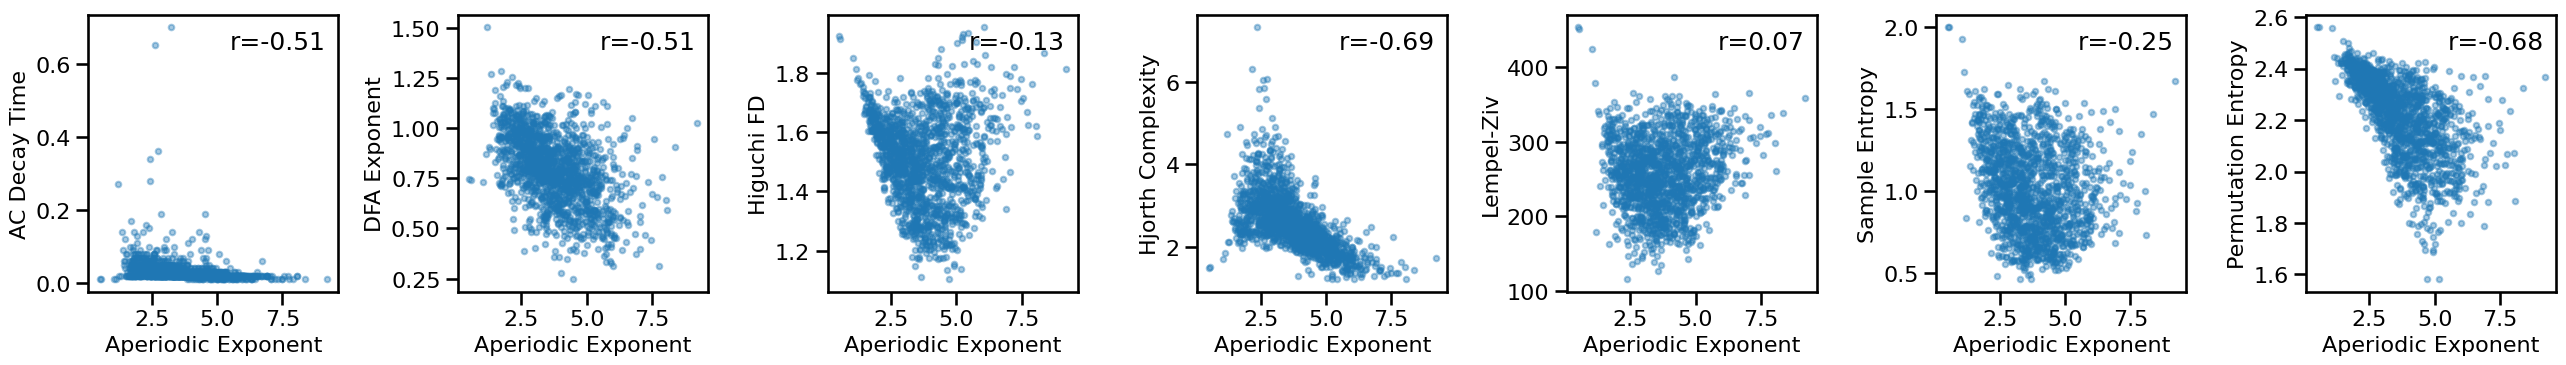

In [69]:
# Plot comparisons between exponent and time series measures
axes = make_axes(1, len(ts_measures), figsize=(26, 4), wspace=0.4)
for ind, meas in enumerate(ts_measures):
    plot_dots(results['specparam_long'], results[meas], **dot_kwargs,
              xlabel='Aperiodic Exponent', ylabel=LABELS[meas], ax=axes[ind])
if SAVE_FIG: plt.savefig(FIGPATH / ('ieeg_exp_ts_scatters.pdf'))

In [70]:
# Check the correlations between time series and exponent measures
for meas in ts_measures:
    print(meas)
    print('    SP-EXP:  ', format_corr(*all_corrs['specparam_long'][meas]))
    print('    IR-EXP:  ', format_corr(*all_corrs['irasa_long'][meas]))

autocorr_decay_time
    SP-EXP:   r=-0.508  CI[-0.549, -0.467],  p=0.000
    IR-EXP:   r=-0.383  CI[-0.429, -0.334],  p=0.000
dfa
    SP-EXP:   r=-0.510  CI[-0.550, -0.468],  p=0.000
    IR-EXP:   r=-0.604  CI[-0.636, -0.570],  p=0.000
higuchi_fd
    SP-EXP:   r=-0.132  CI[-0.185, -0.078],  p=0.000
    IR-EXP:   r=-0.426  CI[-0.472, -0.377],  p=0.000
hjorth_complexity
    SP-EXP:   r=-0.691  CI[-0.721, -0.658],  p=0.000
    IR-EXP:   r=-0.568  CI[-0.607, -0.526],  p=0.000
lempelziv
    SP-EXP:   r=+0.071  CI[+0.021, +0.123],  p=0.006
    IR-EXP:   r=-0.163  CI[-0.212, -0.111],  p=0.000
sample_entropy
    SP-EXP:   r=-0.250  CI[-0.296, -0.202],  p=0.000
    IR-EXP:   r=-0.482  CI[-0.520, -0.442],  p=0.000
perm_entropy
    SP-EXP:   r=-0.684  CI[-0.713, -0.653],  p=0.000
    IR-EXP:   r=-0.871  CI[-0.882, -0.857],  p=0.000


### Compare knee to other measures

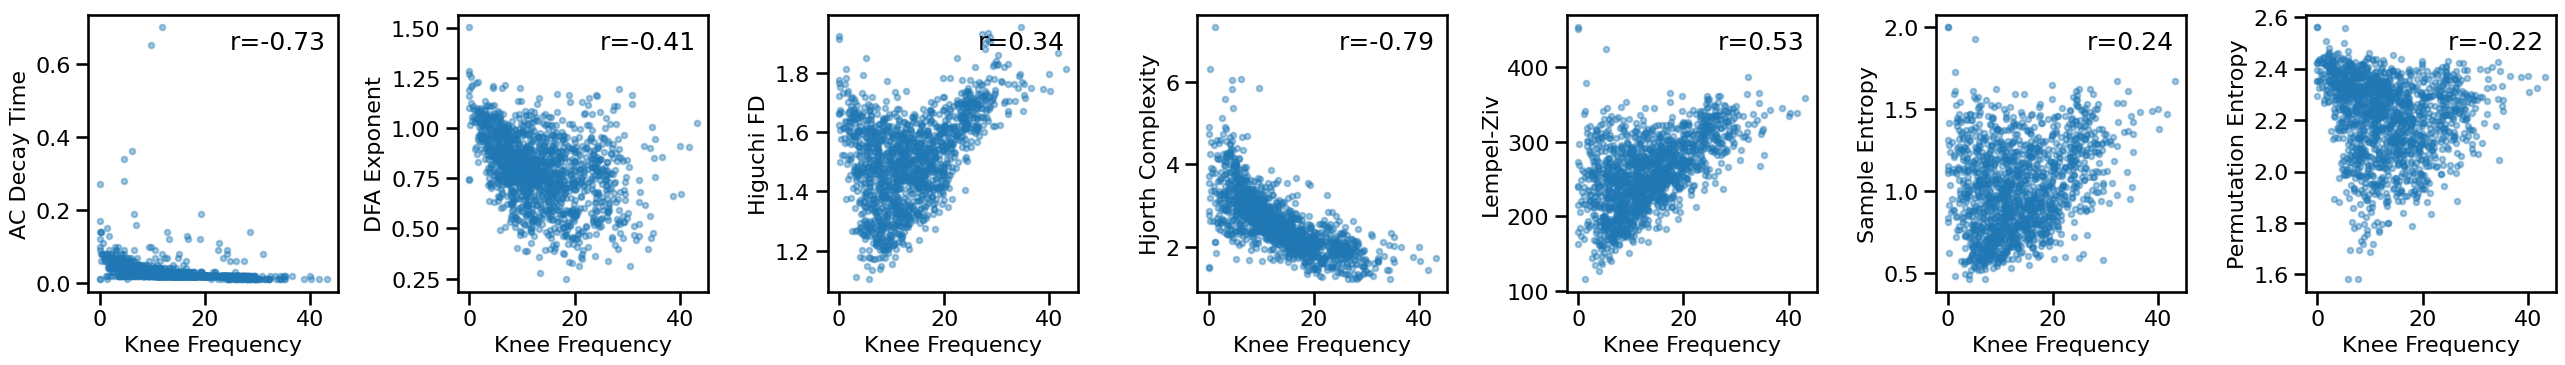

In [71]:
# Plot comparisons between knee and time series measures
axes = make_axes(1, len(ts_measures), figsize=(26, 4), wspace=0.4)
for ind, meas in enumerate(ts_measures):
    plot_dots(results['specparam_knee_freq'], results[meas], **dot_kwargs,
              xlabel='Knee Frequency', ylabel=LABELS[meas], ax=axes[ind])
if SAVE_FIG: plt.savefig(FIGPATH / ('ieeg_knee_ts_scatters.pdf'))

In [72]:
# Check the correlations between time series and knee measures
for meas in ts_measures:
    print(meas)
    print('    KNEE:  \t', format_corr(*all_corrs['specparam_knee'][meas]))
    print('    KNEE-FREQ: \t', format_corr(*all_corrs['specparam_knee_freq'][meas]))

autocorr_decay_time
    KNEE:  	 r=-0.641  CI[-0.677, -0.603],  p=0.000
    KNEE-FREQ: 	 r=-0.730  CI[-0.762, -0.695],  p=0.000
dfa
    KNEE:  	 r=-0.496  CI[-0.539, -0.453],  p=0.000
    KNEE-FREQ: 	 r=-0.409  CI[-0.454, -0.362],  p=0.000
higuchi_fd
    KNEE:  	 r=+0.081  CI[+0.025, +0.136],  p=0.002
    KNEE-FREQ: 	 r=+0.344  CI[+0.290, +0.397],  p=0.000
hjorth_complexity
    KNEE:  	 r=-0.786  CI[-0.811, -0.759],  p=0.000
    KNEE-FREQ: 	 r=-0.793  CI[-0.816, -0.768],  p=0.000
lempelziv
    KNEE:  	 r=+0.290  CI[+0.240, +0.337],  p=0.000
    KNEE-FREQ: 	 r=+0.531  CI[+0.487, +0.573],  p=0.000
sample_entropy
    KNEE:  	 r=-0.036  CI[-0.087, +0.015],  p=0.170
    KNEE-FREQ: 	 r=+0.237  CI[+0.185, +0.288],  p=0.000
perm_entropy
    KNEE:  	 r=-0.505  CI[-0.543, -0.464],  p=0.000
    KNEE-FREQ: 	 r=-0.216  CI[-0.265, -0.164],  p=0.000


### Compare Time Series Measures to Each Other

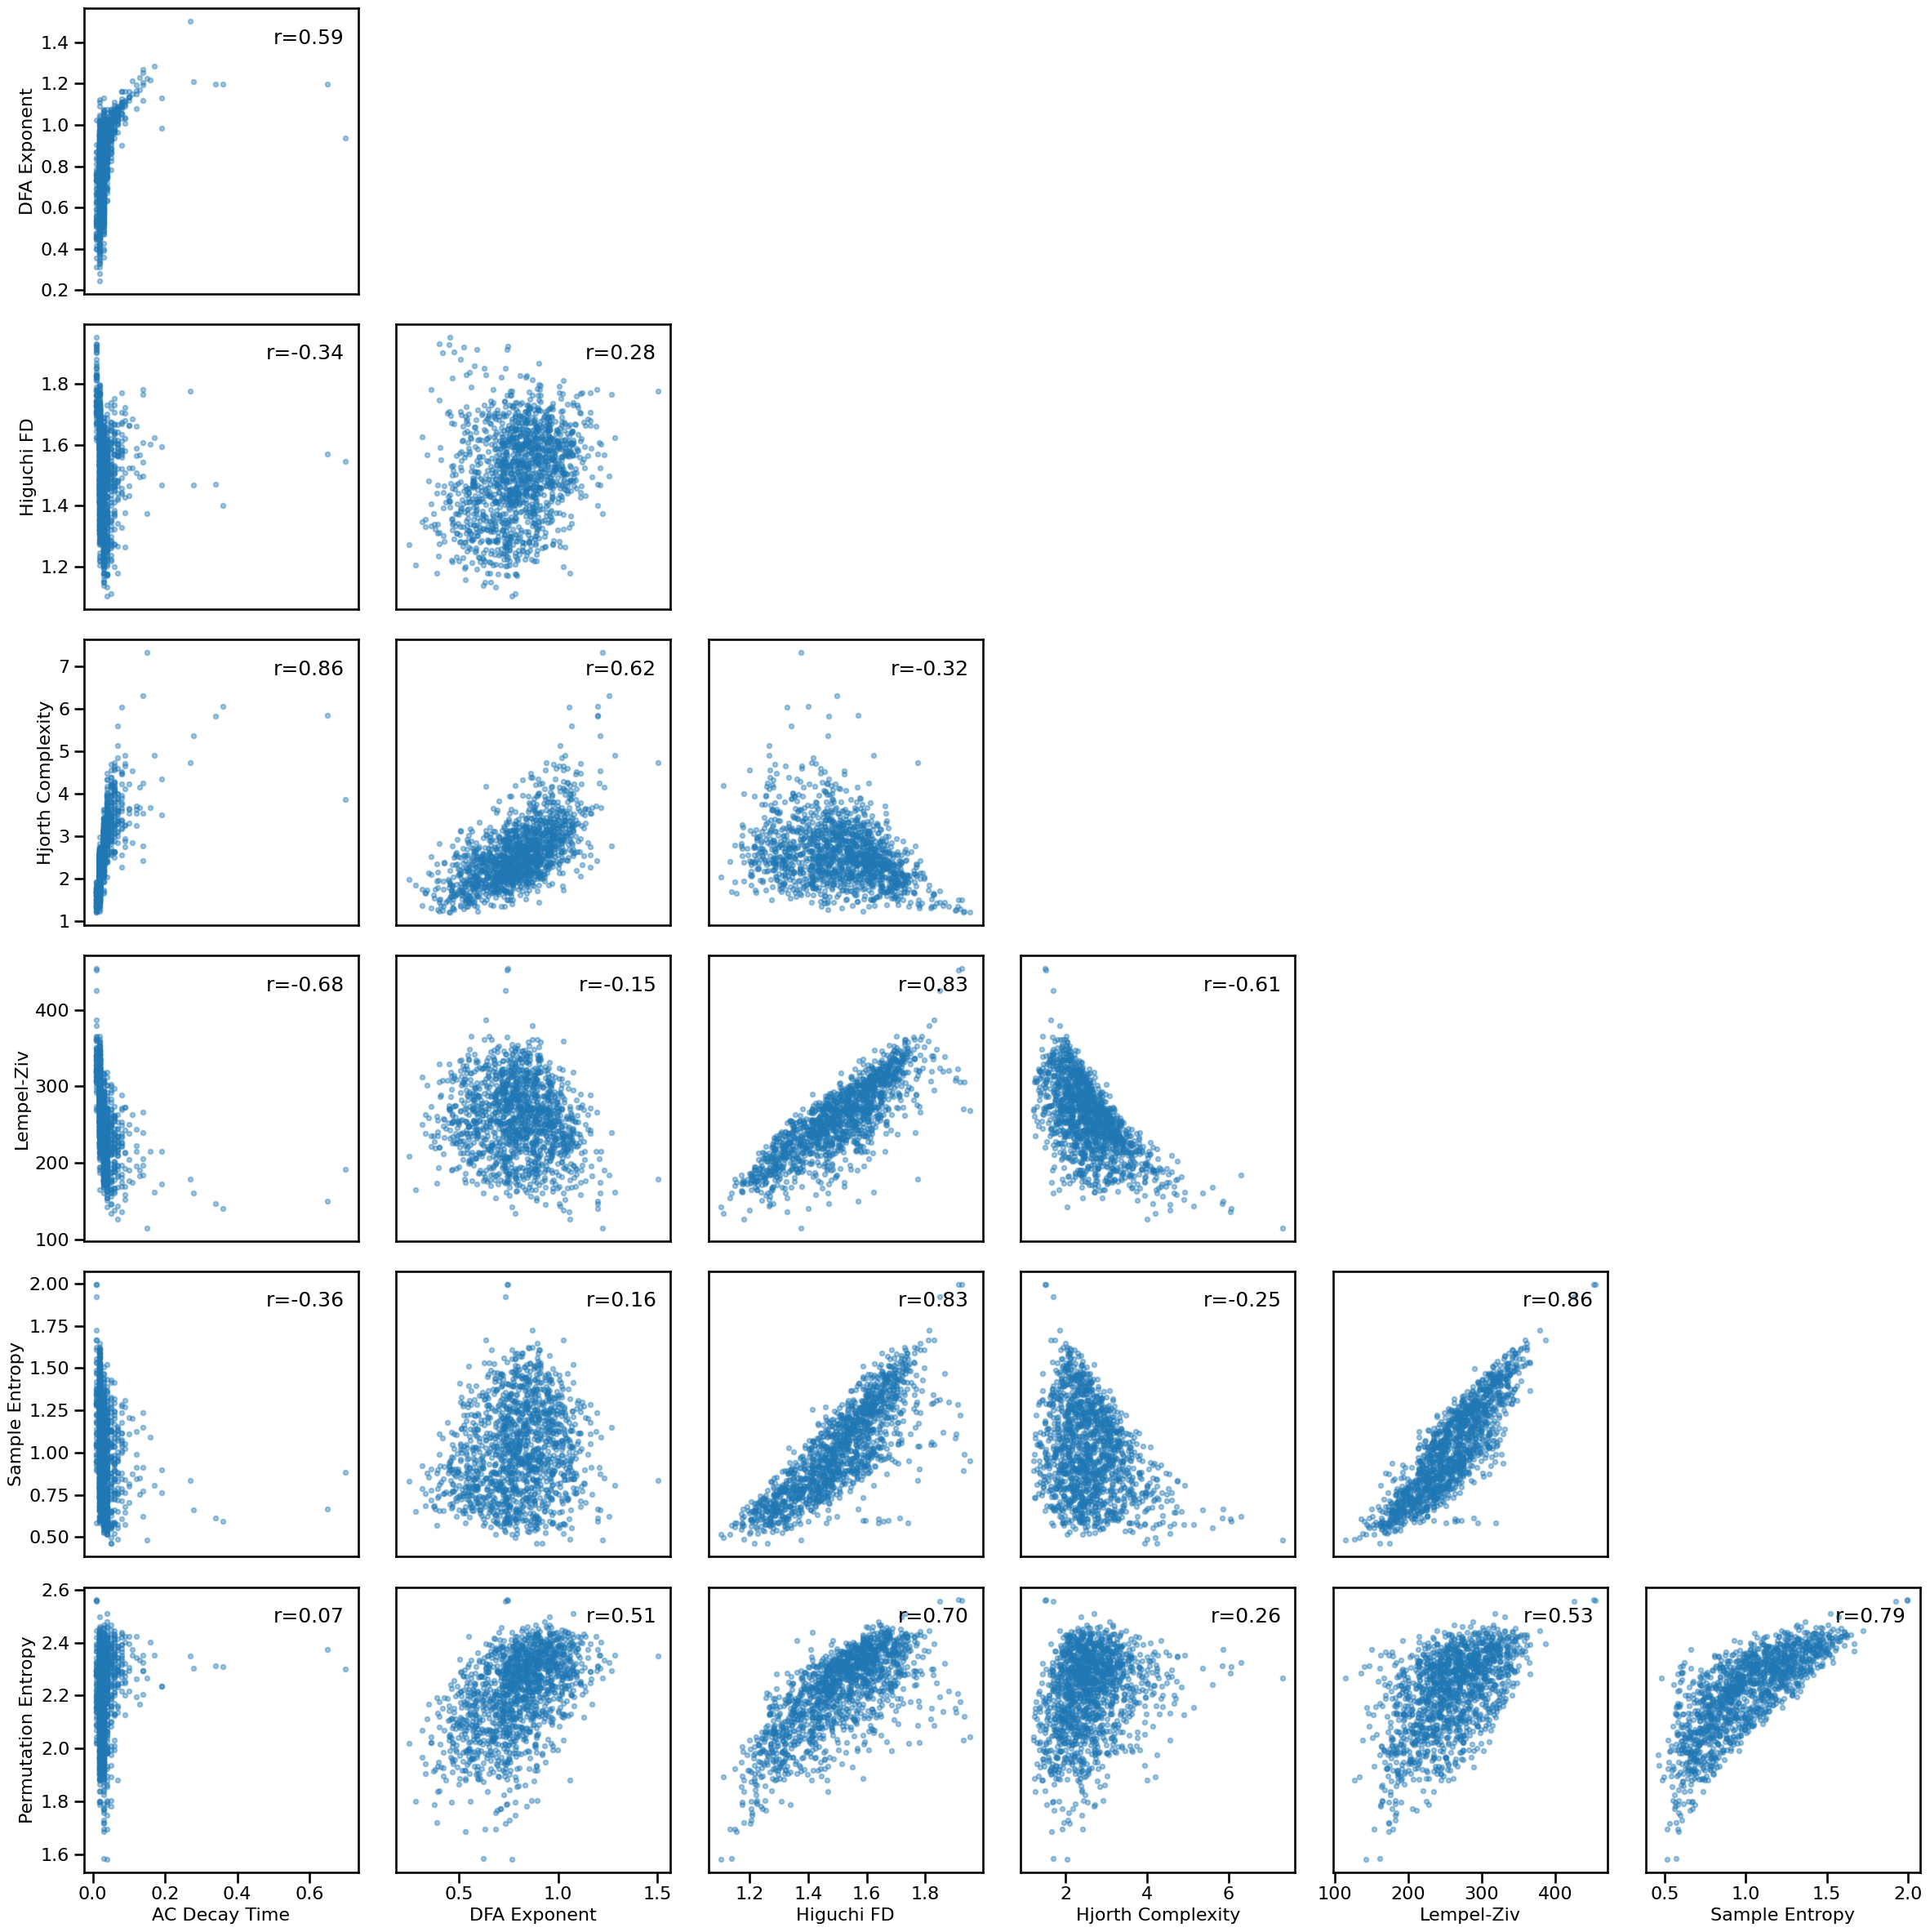

In [73]:
# Plot multi-panel plot comparing all time series measures to each other
plot_results_all(results, ts_measures, **dot_kwargs)

### Correlations

In [74]:
# Subselect time domain measures
all_corrs_ts = {ke : va for ke, va in all_corrs.items() if ke not in exp_measures + knee_measures}

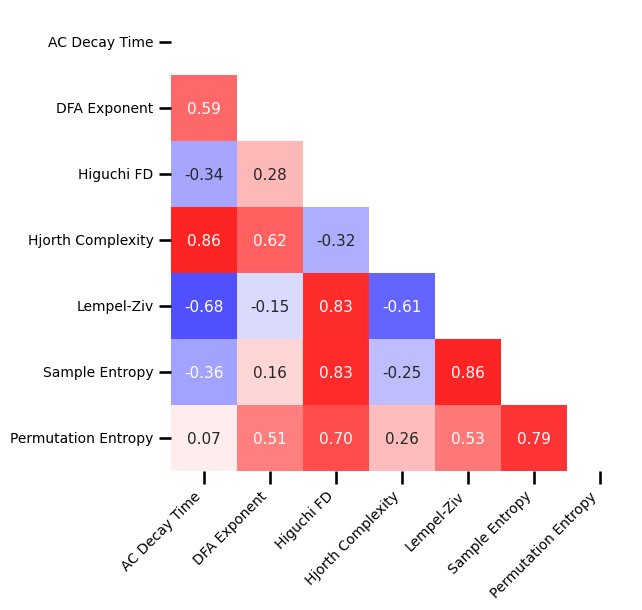

In [75]:
# Plot the correlations matrix across all time series measures
plot_corr_matrix(unpack_corrs(all_corrs_ts), cbar=False, figsize=(6, 6),
                 xticklabels=ts_labels, yticklabels=ts_labels, **fsaver('ieeg_ts_corr_mat'))

#### Exponent Correlations

In [76]:
# Extract the correlations between specparam and time domain measures
exp_corrs_short = np.atleast_2d([all_corrs['specparam_short'][label][0] for label in ts_measures]).T

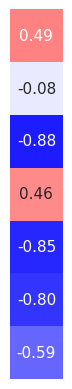

In [77]:
# Plot correlations between exponent and time domain measures
plot_corr_matrix(exp_corrs_short, cbar=False, **fsaver('ieeg_exp_corrs_short'))

In [78]:
# Extract the correlations between specparam and time domain measures
exp_corrs_long = np.atleast_2d([all_corrs['specparam_long'][label][0] for label in ts_measures]).T

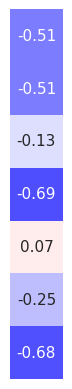

In [79]:
# Plot correlations between exponent and time domain measures
plot_corr_matrix(exp_corrs_long, cbar=False, **fsaver('ieeg_exp_corrs_long'))

#### Knee Correlations

In [80]:
# Extract the correlations between knee and time domain measures
knee_corrs = np.atleast_2d([all_corrs['specparam_knee_freq'][label][0] for label in ts_measures]).T

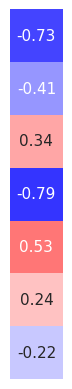

In [81]:
# Plot correlations between knee and time domain measures
plot_corr_matrix(knee_corrs, cbar=False, **fsaver('ieeg_knee_corrs'))

## Compare to Peaks

#### Short Fit Range

In [82]:
# Get peak powers
peak_powers_short = get_band_peak_fg(fg_short, peak_range)[:, 1]

In [83]:
# Check number of nan values
print('# of nan: {}'.format(sum(np.isnan(peak_powers_short))))

# of nan: 0


In [84]:
# Replace nan values with zeros
peak_powers = np.nan_to_num(peak_powers_short)

In [85]:
# Compute correlations between aperiodic measures and peak powers
peak_corrs_short = compute_corrs_to_feature(results, peak_powers_short)

In [86]:
# # Compute differences between correlations between aperiodic measures and peak powers
# peak_corr_diffs = compute_diffs_to_feature(results, peak_powers)

In [87]:
# Check the correlations between peak powers and aperiodic measures
print('Correlations with peak powers:')
for label in peak_corrs_short.keys():
    print('     {:20s}:  '.format(label), format_corr(*peak_corrs_short[label]))

Correlations with peak powers:
     autocorr_decay_time :   r=-0.345  CI[-0.390, -0.299],  p=0.000
     dfa                 :   r=-0.598  CI[-0.632, -0.563],  p=0.000
     higuchi_fd          :   r=-0.442  CI[-0.487, -0.397],  p=0.000
     hjorth_complexity   :   r=-0.478  CI[-0.517, -0.436],  p=0.000
     lempelziv           :   r=-0.190  CI[-0.237, -0.140],  p=0.000
     sample_entropy      :   r=-0.441  CI[-0.482, -0.399],  p=0.000
     perm_entropy        :   r=-0.729  CI[-0.754, -0.703],  p=0.000
     specparam_short     :   r=+0.222  CI[+0.174, +0.270],  p=0.000
     specparam_long      :   r=+0.648  CI[+0.615, +0.678],  p=0.000
     specparam_knee      :   r=+0.567  CI[+0.529, +0.603],  p=0.000
     specparam_knee_freq :   r=+0.394  CI[+0.348, +0.439],  p=0.000
     irasa_short         :   r=+0.330  CI[+0.283, +0.374],  p=0.000
     irasa_long          :   r=+0.769  CI[+0.745, +0.792],  p=0.000
     irasa_knee          :   r=+0.709  CI[+0.681, +0.737],  p=0.000
     irasa_knee_f

In [88]:
# Organize correlations between peak powers and time domain measures
peak_corrs_ts_short = np.atleast_2d([peak_corrs_short[label][0] for label in ts_measures]).T

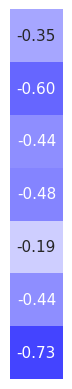

In [89]:
# Plot correlations between peak powers and time domain measures
plot_corr_matrix(peak_corrs_ts_short, cbar=False, **fsaver('ieeg_peak_corrs_short'))

#### Long Fit Range

In [90]:
# Get peak powers
peak_powers_long = get_band_peak_fg(fg_long, peak_range)[:, 1]

In [91]:
# Check number of nan values
print('# of nan: {}'.format(sum(np.isnan(peak_powers_long))))

# of nan: 2


In [92]:
# Replace nan values with zeros
peak_powers_long = np.nan_to_num(peak_powers_long)

In [93]:
# Compute correlations between aperiodic measures and peak powers
peak_corrs_long = compute_corrs_to_feature(results, peak_powers_long)

In [94]:
# Check the correlations between peak powers and aperiodic measures
print('Correlations with peak powers:')
for label in peak_corrs_long.keys():
    print('     {:20s}:  '.format(label), format_corr(*peak_corrs_long[label]))

Correlations with peak powers:
     autocorr_decay_time :   r=-0.251  CI[-0.299, -0.205],  p=0.000
     dfa                 :   r=-0.482  CI[-0.524, -0.439],  p=0.000
     higuchi_fd          :   r=-0.194  CI[-0.247, -0.142],  p=0.000
     hjorth_complexity   :   r=-0.357  CI[-0.400, -0.311],  p=0.000
     lempelziv           :   r=-0.053  CI[-0.103, -0.004],  p=0.042
     sample_entropy      :   r=-0.211  CI[-0.258, -0.164],  p=0.000
     perm_entropy        :   r=-0.407  CI[-0.450, -0.363],  p=0.000
     specparam_short     :   r=+0.019  CI[-0.031, +0.071],  p=0.456
     specparam_long      :   r=+0.349  CI[+0.304, +0.392],  p=0.000
     specparam_knee      :   r=+0.321  CI[+0.276, +0.365],  p=0.000
     specparam_knee_freq :   r=+0.256  CI[+0.210, +0.300],  p=0.000
     irasa_short         :   r=+0.104  CI[+0.053, +0.154],  p=0.000
     irasa_long          :   r=+0.386  CI[+0.343, +0.429],  p=0.000
     irasa_knee          :   r=+0.364  CI[+0.320, +0.407],  p=0.000
     irasa_knee_f

In [95]:
# Organize correlations between peak powers and time domain measures
peak_corrs_ts_long = np.atleast_2d([peak_corrs_long[label][0] for label in ts_measures]).T

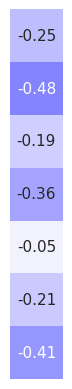

In [96]:
# Plot correlations between peak powers and time domain measures
plot_corr_matrix(peak_corrs_ts_long, cbar=False, **fsaver('ieeg_peak_corrs_long'))

## Conclusions

The iEEG data broadly replicates analyses on the EEG datasets. 